# ***Brain Tumor Analysis***
In this project we are going to predict wether if it is a **Brain Tumor** or not, using **Magnetic Resonance Imaging** *(MRI)*, from Kaggle.

## **Get Data**
Here we extract our data and give the right label to each image.

In [2]:
import os
import pandas as pd

paht_yes = "brain_tumor_datasets/yes"
path_no = "brain_tumor_datasets/no"

data = []

def extract_images(folder, label):
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        if os.path.isfile(filepath):
            data.append({"image": filepath, "label": label})

extract_images(paht_yes, label=1)
extract_images(path_no, label=0)

df = pd.DataFrame(data)
df

,image,label
0,brain_tumor_datasets/yes\Y1.jpg,1
1,brain_tumor_datasets/yes\Y10.jpg,1
2,brain_tumor_datasets/yes\Y100.JPG,1
3,brain_tumor_datasets/yes\Y101.jpg,1
4,brain_tumor_datasets/yes\Y102.jpg,1
...,...,...
248,brain_tumor_datasets/no\No18.jpg,0
249,brain_tumor_datasets/no\No19.jpg,0
250,brain_tumor_datasets/no\No20.jpg,0
251,brain_tumor_datasets/no\No21.jpg,0


Here we used *os* and *pandas* libraries to create a dataframe and insert all the images by their labels. We firstly created 2 variables named *'path_yes'* and *'path_no'*, to append all the images that is or not a Tumor.

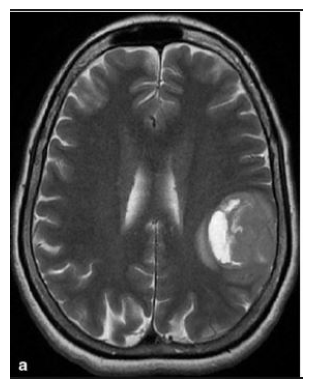

Cancer (1/0) -> 1


In [3]:
# Show the first image just to be sure ist everything alright
from matplotlib import pyplot as plt
from PIL import Image

def get_image_by_pos(df, image_feature, label_feature, pos):
    img_path = df[image_feature][pos]

    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    print(f"Cancer (1/0) -> {df[label_feature][pos]}")

get_image_by_pos(df, image_feature='image', label_feature='label', pos=154)

Just to check that the images were correctly appended, we created a function that receive the dataset, the name of the feature with all the images path, the label feature and the position that want to show, to return the image of the brain and if has cancer or not.
As we can see our images are extracted correclty.

### *Shuffle Dataset*

As we can see, our dataset has some complications, such as the data not being mixed up, in other words, the first images show those without cancer, while the following images show those with cancer. This is a problem because when we want to train the model and divid it into training, validation and test data, the model won't be able to lean the patterns of waht a 'cancer' is. For example, if we splt the dataset at the moment so that the first images are in the training data and the last images are in the test data, there's a huge chance that the model will only be able to learn from the images of the brain without cance, and that when ir comes to testing it will only pick up the images that have cancer. as a result, the model won't be able to learn any pattern and will only be able to predict images that don't have cancer. However, we'll mix up the data so that when we train the neural network, the model can learn all possible patterns.

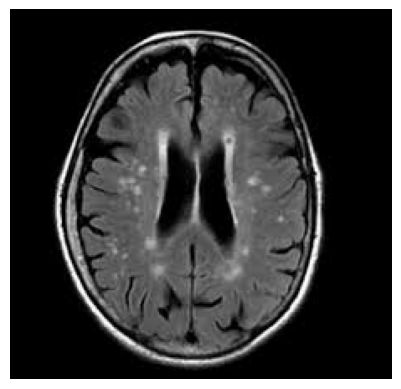

Cancer (1/0) -> 0


In [4]:
df = df.sample(frac=1).reset_index(drop=True)
get_image_by_pos(df, image_feature='image', label_feature='label', pos=15)

As we can see now, our dataset has been shuffle correctly.

## **Exploratory Data Analysis (EDA) & Pre-Processing**
In this chapter, we will understand our data and make some changes if we think it needed.

For start, we will use bar chart to see if our data is balancing.

C:\Users\diogo\AppData\Local\Temp\ipykernel_17428\1391575434.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='label', y='count', data=counts, palette="hls")


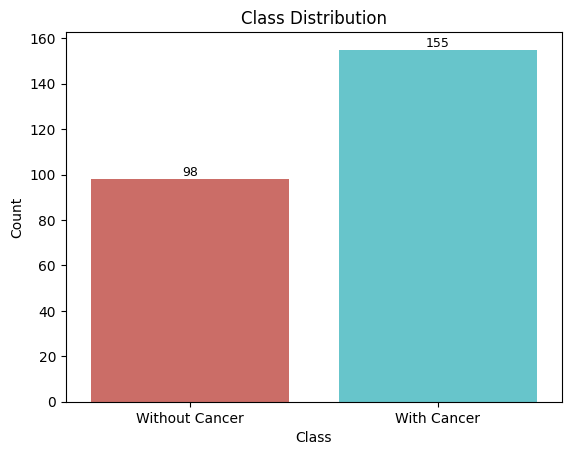

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

counts = df['label'].value_counts().reset_index()

ax = sns.barplot(x='label', y='count', data=counts, palette="hls")

ax.bar_label(ax.containers[0], fontsize=9)
ax.bar_label(ax.containers[1], fontsize=9)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([1, 0], ['With Cancer', 'Without Cancer'])
plt.show()

([<matplotlib.patches.Wedge at 0x24ae9679390>,
 [Text(-0.38120945169250126, 1.0318330068089034, '0'),
  Text(0.38467520731048527, -1.0412132273845909, '1')],
 [Text(-0.20793242819590976, 0.5628180037139473, '61.3%'),
  Text(0.21139808690035675, -0.5721982600942345, '38.7%')])

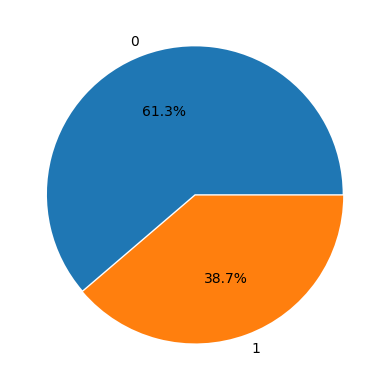

In [62]:
labels = df['label'].unique()

fig, ax = plt.subplots()
ax.pie(counts['count'], explode=(0.0, 0.01), labels=labels, autopct='%1.1f%%')

These images show that there is imbalance, where the 'With Cancer' class (1) has significantly more samples than the 'Without Cancer' class (0). This type of imbalance can lead to problems when training the model, such as:
- **Biased Model ->** The model can learn to predict mostly the dominant class ('With Cancer'), ignoring the characteristics of the minority class.

- **Low Sensitivity to the minority class ->** This can be critical in medical problems, as errors such as false negatives (diagnosing 'No Cancer' when ther is cancer) can have serious consequences.

- **Misleading Metrics ->** Accuracy can be misleading because when evaluating the model the accuracy can be shown to be 85 or more, wrongly inferring that the model is making good predictions. However, what is actually happening is that the model can only predict the majority class and cannot make predictions for the minority class.

To prevent this, we will use techniques such as *Smote*, *adjusting the model weights* and *Data Augmentation.*

### *Split Data*
So that we use the Smote only for training dataset, we will split our data before all the *EDA* and *Pre-Processing*.

In [80]:
from sklearn.model_selection import train_test_split

train_val_data, test_data = train_test_split(df, test_size=0.29, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.41, random_state=42)

train_data.shape, val_data.shape, test_data.shape

((105, 2), (74, 2), (74, 2))

The code shows some specific numbers in the `test_size`, so that validation and test datasets can have the same number of rows making our dataset split.

### **Dealing with Imbalanced Data**

Here, we will use Smote to increase the number of examples in the minority class by replicating existing samples or generating new synthetic sample.

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
train_data = 